## Classify Fashion MNIST

Plan
* Train a simple model
    * Create a model
    * Set loss function
    * optimisation function
    * calculate and update gradients via epoch loops
    * in the end of each epoch calculate test accuracy
* Validate on test data set

### Import Dataset

In [1]:
import torch
from torchvision import datasets, transforms
import helper
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

> NOTE: images will be flattened from 28 by 28 to 28X28

> Image batch shape : there are 64 images with the shape of 28 pixels by 28 pixels

In [2]:
image,label = next(iter(testloader))

## Network Design

In [3]:
import torch.nn.functional as F
from torch import nn


class Network(nn.Module):
    def __init__(self,input_shape,output_shape):
        ''' 
            args:
                input_shape int: number of features in the input images
                outpu_shape int: number of classes to which images will be classifed
        '''
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        # fully connected layers
        self.fc1 = nn.Linear(self.input_shape, 128) # outputs 128 values (128*input_shape weights + 128 biases)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, self.output_shape) 
        self.dp  = nn.Dropout(p=0.1)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits ''' 
        
        # pass it through the network
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dp(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        
        return x
sample_image = image.view(image.shape[0], -1)# flatten the sample image
model = Network(input_shape = sample_image.shape[1],output_shape=10)
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dp): Dropout(p=0.1, inplace=False)
)


## Set Loss and Optimizer

In [4]:
from torch import optim
criterion = nn.NLLLoss() # Loss function Negative log likelyhood loss
optimizer = optim.Adam(model.parameters(), lr=0.01) #  learning rate 0.003

> Note: soft_max activation cannot be used with NLLLoss loss function instead log_softmax was used

## Train the model

In [5]:
def accuracy(y_hat_tensor,label_tensor):
    '''
    args:
        y_hat_tensor tensor: direct output of the model. 
        label_tensor tensor: actual labels of the given items
    returns:
        accuracy float
        accurate float: number of accurately labeled items
        total_samples float : number of samples investigated
    '''
    y_hat_tensor = torch.exp(y_hat_tensor)
    values, pred_labels = y_hat_tensor.max(1) # works like numpy argmax plus returns the values of the cells.
    accurate = sum(1 for a, b in zip(pred_labels.numpy(), label_tensor.numpy()) if a == b)
    total_samples = len(label_tensor)
    accuracy = accurate/total_samples
    return accuracy,accurate,total_samples


In [7]:
epochs = 30
epoch = 0
train_losses = []
test_losses = []
for e in range(epochs):
    running_loss = 0
    total_accurate = 0
    total_samples = 0
    for images, labels in trainloader:
        #flaten the images
        images = images.view(images.shape[0], -1)
        # Training pass
        output = model(images) # directly passes the images into forward method
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_train_accuracy,accurate,total_sample = accuracy(output,labels)
        running_loss += loss.item()
        total_accurate += accurate
        total_samples += total_sample
    else:
        with torch.no_grad():
            model.eval()
            test_loss = 0
            total_samples_test = 0
            total_accurate_test = 0
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                output = model(images)
                test_loss += criterion(output, labels)
                batch_test_accuracy,accurate_test,total_sample_test = accuracy(output,labels)
                total_accurate_test += accurate_test
                total_samples_test += total_sample_test
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        print('''---------- epoch : {} -----------'''.format(epoch+1))
        print(''' Training Accuracy = {}  - Training Loss = {}'''.format(total_accurate/total_samples,running_loss/len(trainloader)))
        print(''' Test Accuracy = {}  - Test Loss = {}'''.format(total_accurate_test/total_samples_test,test_loss/len(testloader)))
        epoch += 1

---------- epoch : 1 -----------
 Training Accuracy = 0.8300833333333333  - Training Loss = 0.49264484459657404
 Test Accuracy = 0.817  - Test Loss = 0.5022813081741333
---------- epoch : 2 -----------
 Training Accuracy = 0.8325833333333333  - Training Loss = 0.48753152724140997
 Test Accuracy = 0.8402  - Test Loss = 0.48401767015457153
---------- epoch : 3 -----------
 Training Accuracy = 0.8340833333333333  - Training Loss = 0.4835210707046584
 Test Accuracy = 0.8221  - Test Loss = 0.509443998336792
---------- epoch : 4 -----------
 Training Accuracy = 0.8305833333333333  - Training Loss = 0.49733108987432045
 Test Accuracy = 0.8357  - Test Loss = 0.47510018944740295
---------- epoch : 5 -----------
 Training Accuracy = 0.8386833333333333  - Training Loss = 0.4706632491590372
 Test Accuracy = 0.8258  - Test Loss = 0.5138647556304932
---------- epoch : 6 -----------
 Training Accuracy = 0.8367166666666667  - Training Loss = 0.48114153658593894
 Test Accuracy = 0.8377  - Test Loss = 0

### Plot Train and Test Losses

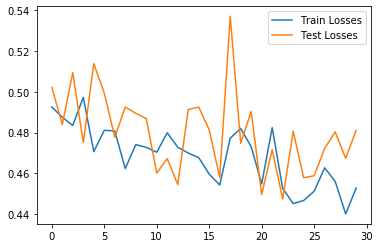

In [8]:
plt.plot(train_losses,label='Train Losses')
plt.plot(test_losses,label='Test Losses')
plt.legend()

## Display Results

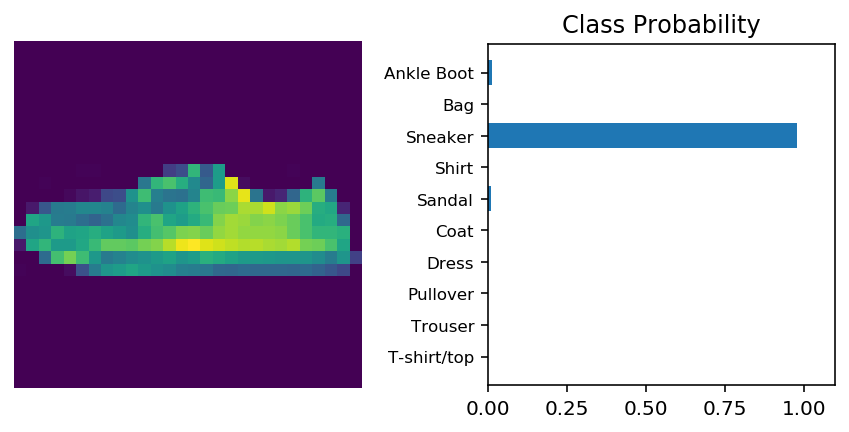

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper1

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)
#Calculate the class probabilities (softmax) for img
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
# Plot the image and probabilities
helper1.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')